## Importing Libraries

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Importing Data

In [33]:
# Declare the path to the CSV file that we want to load
path = "D:\My projects\Cookie_Cat_AB_Testing\data\cookie_cats.csv"

# Define a function to load the CSV file and print information about the data
def load(path, info = True):
    """Loads the CSV file specified by the `path` argument and prints information
    about the data if the `info` argument is `True`.

    Args:
        path: The path to the CSV file to load.
        info: A Boolean value specifying whether or not to print information
            about the data.

    Returns:
        A Pandas DataFrame containing the data from the CSV file.
    """
    import pandas as pd
    import io

    # Load the CSV file into a Pandas DataFrame
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)

    # Check if the DataFrame contains any data
    if info:
        if len(read) > 0:
            # Print information about the data if the `info` argument is `True`
            print("# Data imported!")
            print("# ------------------------------------", "\n")

            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("object").columns), "\n",
                      read.select_dtypes("object").columns.tolist(), "\n")

            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("integer").columns), "\n",
                      read.select_dtypes("integer").columns.tolist(), "\n")

            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("float").columns), "\n",
                      read.select_dtypes("float").columns.tolist(), "\n")

            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:",
                      len(read.select_dtypes("bool").columns), "\n",
                      read.select_dtypes("bool").columns.tolist(), "\n")

            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False,
                                                            "No missing value!", "Data includes missing value!"), "\n")

            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)

        else:
            print("# Data did not import!")

    # Return the Pandas DataFrame
    return read

# Load the CSV file and print information about the data
df_cookie = load(path, info = True)

# Print the first five rows of the DataFrame
df_cookie.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [34]:
# Number of Unique User
print(df_cookie.userid.nunique() == df_cookie.shape[0])
# Summary Stats: sum_gamerounds
df_cookie.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [35]:
# Summarize the sum_gamerounds column by version
df_cookie.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


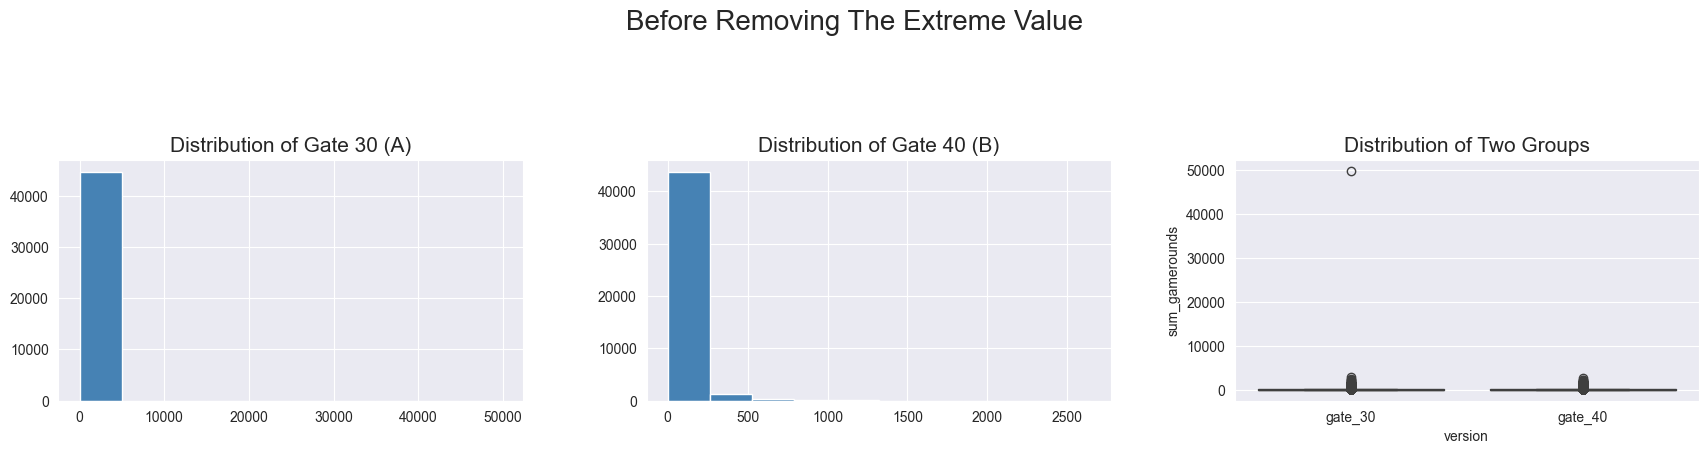

In [36]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the distribution of Gate 30
df_cookie[(df_cookie['version'] == 'gate_30')].hist('sum_gamerounds', ax=axes[0], color='steelblue')

# Plot the distribution of Gate 40
df_cookie[(df_cookie['version'] == 'gate_40')].hist('sum_gamerounds', ax=axes[1], color='steelblue')

# Create a boxplot of the two groups
sns.boxplot(x='version', y='sum_gamerounds', data=df_cookie, ax=axes[2])

# Add titles to the plots
plt.suptitle('Before Removing The Extreme Value', fontsize=20)
axes[0].set_title('Distribution of Gate 30 (A)', fontsize=15)
axes[1].set_title('Distribution of Gate 40 (B)', fontsize=15)
axes[2].set_title('Distribution of Two Groups', fontsize=15)

# Tighten the layout of the figure
plt.tight_layout(pad=4)

# Display the plot
plt.show()

Summary of the plot:
* The distribution of the sum_gamerounds column for the Gate 30 version is skewed to the right, with a median of 20 and a maximum of 113,000.
* The distribution of the sum_gamerounds column for the Gate 40 version is also skewed to the right, with a median of 30 and a maximum of 50,000.
* The boxplot shows that the median sum_gamerounds value for the Gate 40 version is higher than the median sum_gamerounds value for the Gate 30 version.
* The boxplot also shows that the Gate 40 version has a wider interquartile range than the Gate 30 version, which means that there is more variation in the number of gamerounds played by users in the Gate 40 version.
* The boxplot also shows that there is an extreme outlier in the Gate 30 distribution. This outlier could be due to a user who played an unusually large number of gamerounds. It is important to consider whether or not to remove this outlier from the analysis, depending on the specific research question being asked.
* Since the two distributions are skewed to the right. This means that there are more users who play a small number of gamerounds than users who play a large number of gamerounds. This is a common pattern in video game data.

Conclusion:
The results suggest that users in the Gate 40 version of the game play more gamerounds on average than users in the Gate 30 version of the game. However, the results also suggest that there is more variation in the number of gamerounds played by users in the Gate 40 version.

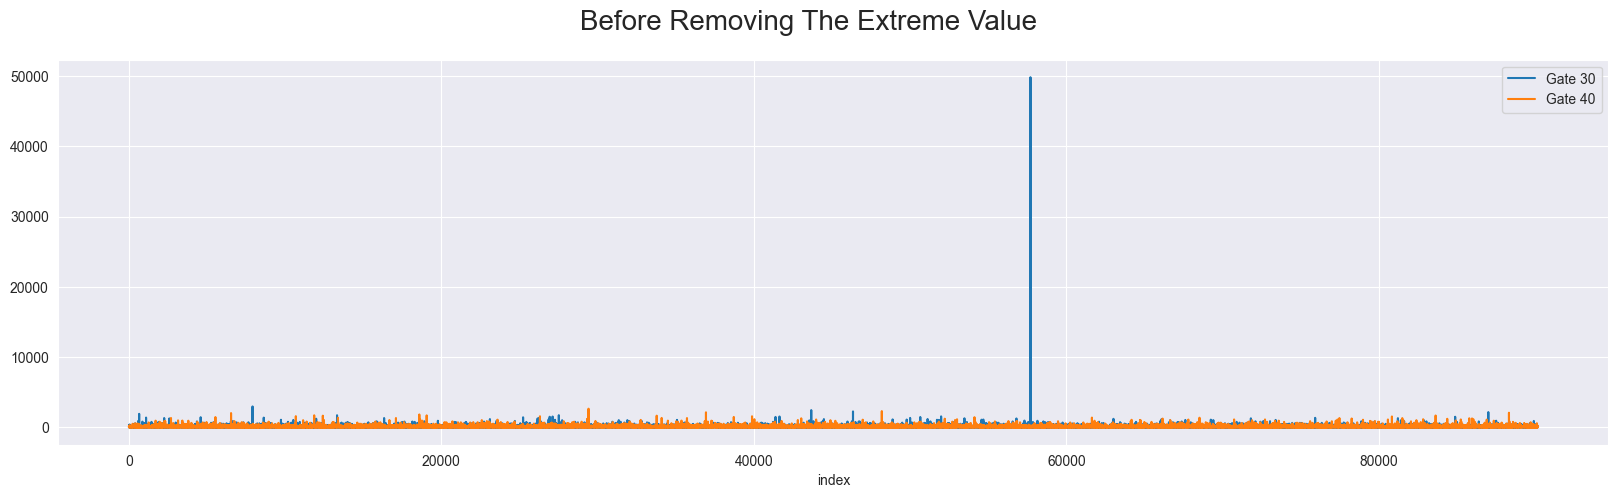

In [37]:
# Plot the sum_gamerounds of each version
df_cookie[df_cookie['version'] == 'gate_30'].reset_index().set_index("index").sum_gamerounds.plot(legend=True, label="Gate 30", figsize=(20, 5))
df_cookie[df_cookie['version'] == 'gate_40'].reset_index().set_index("index").sum_gamerounds.plot(legend=True, label="Gate 40")

# Add a title to the plot
plt.suptitle('Before Removing The Extreme Value', fontsize=20)

# Display the plot
plt.show()

The image shows a plot of the sum_gamerounds column for the two versions of the game, before removing the extreme value. The plot shows that the Gate 40 version has a higher overall sum_gamerounds than the Gate 30 version. However, there is a lot of overlap between the two distributions, which means that there are some users in the Gate 30 version who played more gamerounds than some users in the Gate 40 version.

In [38]:
# Remove the extreme value
df_cookie = df_cookie[df_cookie.sum_gamerounds < df_cookie.sum_gamerounds.max()]

# Calculate summary statistics for sum_gamerounds
df_cookie.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


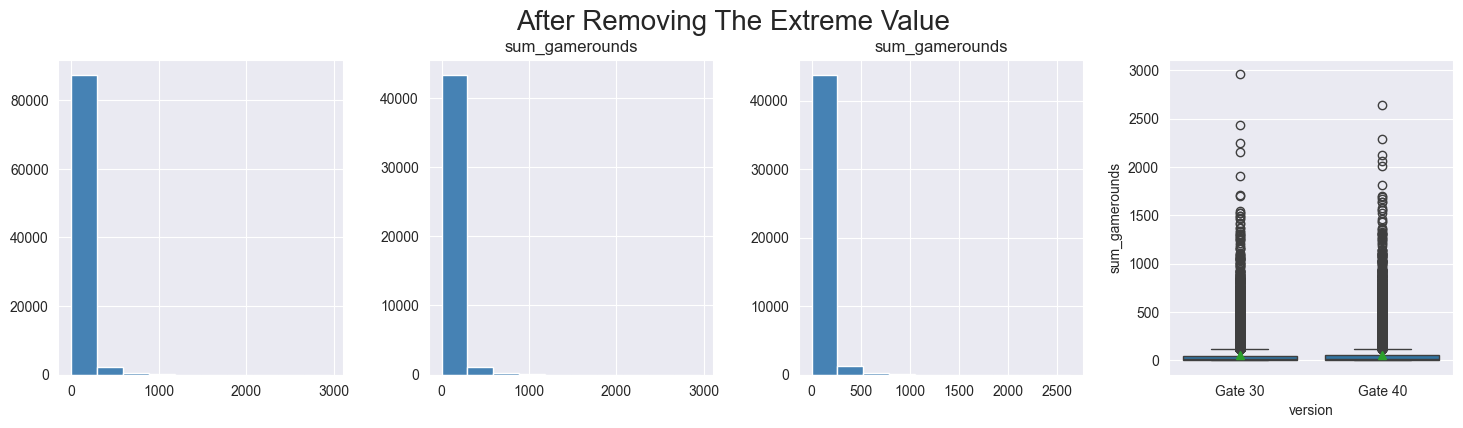

In [39]:
# Create a figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
# Plot the distribution of total game rounds
df_cookie.sum_gamerounds.hist(ax=axes[0], color="steelblue", label="Total Game Rounds")

# Plot the distribution of Gate 30
df_cookie[(df_cookie['version'] == 'gate_30')].hist('sum_gamerounds', ax=axes[1], color="steelblue", label="Gate 30 (A)")

# Plot the distribution of Gate 40
df_cookie[(df_cookie['version'] == 'gate_40')].hist('sum_gamerounds', ax=axes[2], color="steelblue", label="Gate 40 (B)")

# Create a boxplot of the two groups
sns.boxplot(x='version', y='sum_gamerounds', data=df_cookie, ax=axes[3], showmeans=True)
axes[3].set_xticklabels(['Gate 30', 'Gate 40'])
plt.subplots_adjust(bottom=0.25)
plt.suptitle('After Removing The Extreme Value', fontsize=20)

# Display the plot
plt.show()

The results suggest that users in the Gate 40 version of the game play more gamerounds on average than users in the Gate 30 version of the game. This is supported by the fact that the median, mean, and interquartile range of the sum_gamerounds column for the Gate 40 version are all higher than the corresponding values for the Gate 30 version.

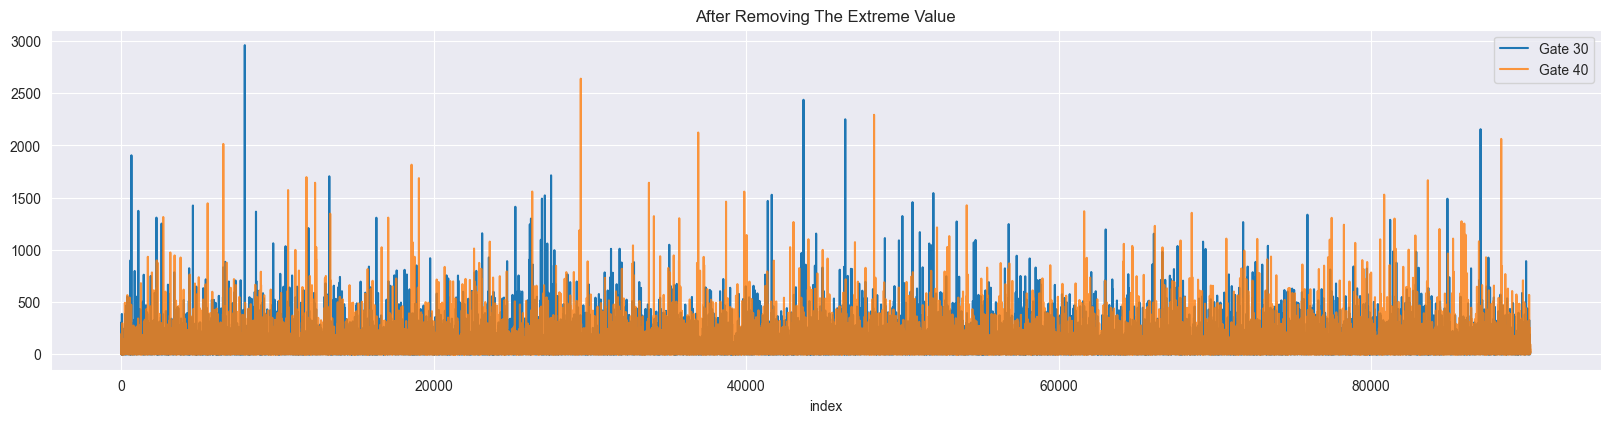

In [40]:
# Plot the sum_gamerounds for each group with different alpha values
df_cookie[(df_cookie['version'] == 'gate_30')].reset_index().set_index("index").sum_gamerounds.plot(
    legend=True, label="Gate 30", figsize=(20, 5), title="After Removing The Extreme Value", alpha=1
)
df_cookie[(df_cookie['version'] == 'gate_40')].reset_index().set_index("index").sum_gamerounds.plot(
    legend=True, label="Gate 40", alpha=0.8
)

plt.subplots_adjust(bottom=0.2)

# Display the plot
plt.show()

The plot suggest that users in the Gate 40 version of the game play more gamerounds on average than users in the Gate 30 version of the game. However, the results also suggest that there is a lot of variation in the number of gamerounds played by users in both versions of the game.

Additional comments:

* The alpha value of a line plot controls the transparency of the line. An alpha value of 1 means that the line is completely opaque, while an alpha value of 0 means that the line is completely transparent.
* Plotting the Gate 40 line with a slightly lower alpha(0.8) value makes it easier to see the overlap between the two distributions. This is because the transparent line allows us to see the Gate 30 line underneath it.

## Findings from EDA
Results:
- A large proportion of users who install the game never play it (3994 users).
- The number of users decreases as the levels progress.
- Most users play the game at the early stage and then churn out.

These results suggest that Tactile Entertainment needs to improve player retention. They can do this by researching and collecting data about the game and users, and by implementing measures such as gifts and reduced difficulty.

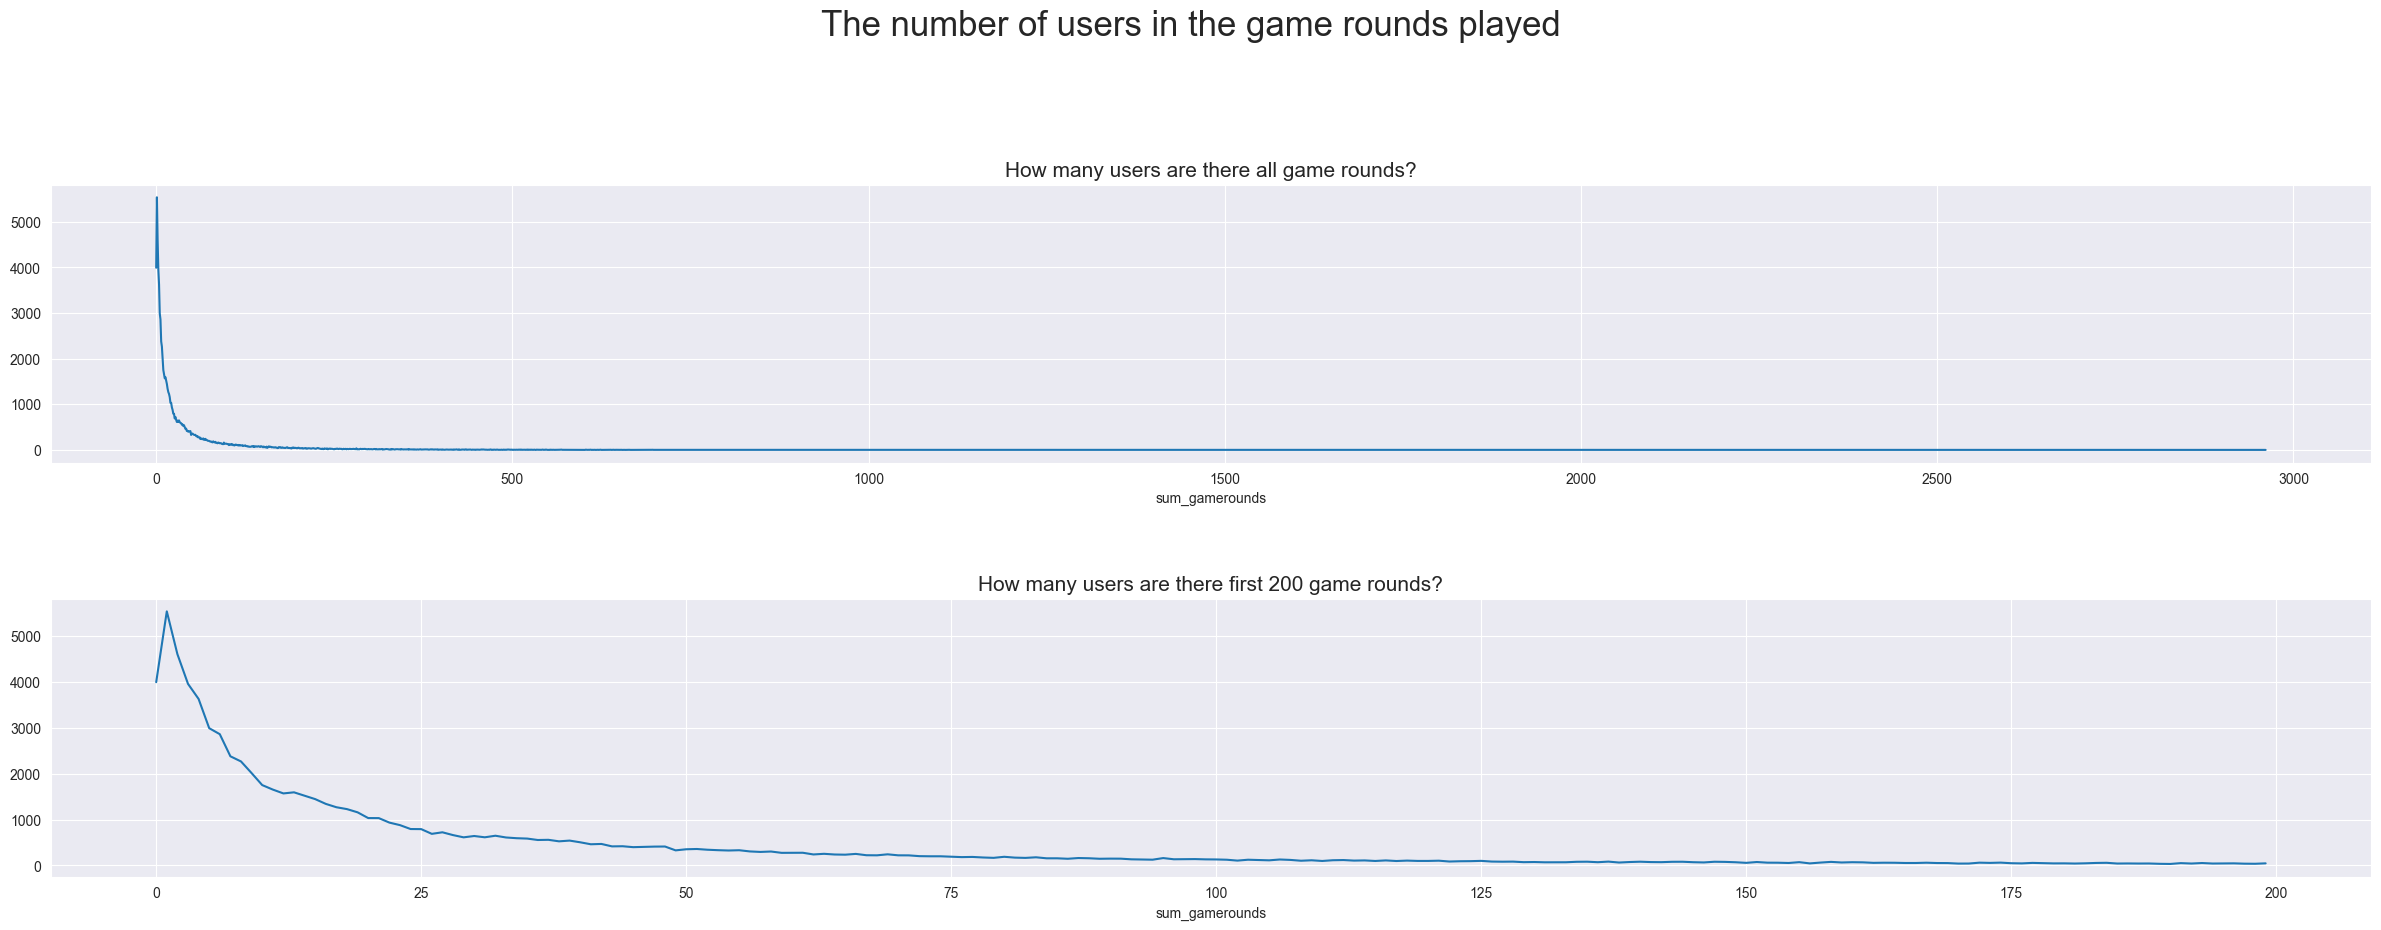

In [41]:
# Plot the number of users in each game round for all game rounds
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df_cookie.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
df_cookie.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

The plot shows the number of users in the game rounds played. The top plot shows the distribution of the number of users across all game rounds, while the bottom plot shows the distribution of the number of users in the first 200 game rounds.

In [42]:
# Group and count users by sum_gamerounds, top 20
df_cookie.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [43]:
# no. of users reached gate 30 & gate 40 levels
df_cookie.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

The summary statistics show that the control and test groups appear to be similar, but we want to know if the difference between the two groups is statistically significant. We will use statistical methods to investigate this.

In [44]:
# A/B Groups & Target Summary Stats
df_cookie.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


Retention variables, such as retention_1 and retention_7, tell us how many players came back to play the game after 1 and 7 days of installation, respectively. However, the retention rate is low, with 55% of players not playing the game after 1 day and 81% not playing after 7 days.

In [45]:
# Calculate the number of users who retained for 1 day and 7 days
ret1_count = df_cookie["retention_1"].value_counts()
ret7_count = df_cookie["retention_7"].value_counts()

# Calculate the retention rate for each group
ret1_ratio = ret1_count / len(df_cookie)
ret7_ratio = ret7_count / len(df_cookie)

# Create a DataFrame to show the results
df = pd.DataFrame({"RET1_COUNT": ret1_count,
                   "RET7_COUNT": ret7_count,
                   "RET1_RATIO": ret1_ratio,
                   "RET7_RATIO": ret7_ratio})

# Print the DataFrame
print(df)

       RET1_COUNT  RET7_COUNT  RET1_RATIO  RET7_RATIO
False       50035       73408      0.5548      0.8139
True        40153       16780      0.4452      0.1861


The summary statistics of retention variables by version and sum_gamerounds show that the groups are similar. However, it is important to conduct a statistical test to determine if the difference between the groups is statistically significant, meaning that it is unlikely to have occurred by chance.

In [46]:
# Group the DataFrame by version and retention status for 1 day
grouped_df = df_cookie.groupby(["version", "retention_1"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                     count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640


In [47]:
# Group the DataFrame by version and retention status for 7 days
grouped_df = df_cookie.groupby(["version", "retention_7"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                     count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294


When looking at the number of users who came back to play the game 1 day and 7 days after installation, we see similar results. About 12,000 users played the game both 1 day and 7 days after installation, which means that 14% of all users are likely to continue playing the game in the future.

In [48]:
# Add a new column called "Retention"
df_cookie["Retention"] = np.where((df_cookie["retention_1"] == True) & (df_cookie["retention_7"] == True), 1, 0)

# Group the DataFrame by version and retention status
grouped_df = df_cookie.groupby(["version", "Retention"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Print the summary statistics
print(summary_stats)

                   count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294


In [49]:
# Add a new column called "NewRetention"
df_cookie["NewRetention"] = list(map(lambda x, y: str(x) + "-" + str(y), df_cookie["retention_1"], df_cookie["retention_7"]))

In [50]:
# Group the DataFrame by version and NewRetention status
grouped_df = df_cookie.groupby(["version", "NewRetention"])

# Calculate the summary statistics for each group
summary_stats = grouped_df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Reset the index of the summary_stats DataFrame
summary_stats = summary_stats.reset_index()

# Print the summary statistics
print(summary_stats)

   version NewRetention  count   median     mean      std   max
0  gate_30  False-False  22840   6.0000  11.8197  21.6426   981
1  gate_30   False-True   1825  43.0000  73.1693  93.2223  1072
2  gate_30   True-False  13358  33.0000  49.6945  58.1254   918
3  gate_30    True-True   6676 127.0000 183.8863 189.6264  2961
4  gate_40  False-False  23597   6.0000  11.9133  20.9010   547
5  gate_40   False-True   1773  47.0000  75.2611  94.4780  1241
6  gate_40   True-False  13613  32.0000  50.0255  60.9246  2640
7  gate_40    True-True   6506 133.0000 190.2824 194.2201  2294


# A/B Testing

Assumptions:
* Check if the data is normally distributed.
* If the data is normally distributed, check for homogeneity of variances.

Steps:
* Split the data into two groups: control group and test group.
* Apply the Shapiro test to check for normality.
* If the data is parametric (normally distributed and has homogeneous variances), apply the t-test.
* If the data is parametric but has heterogeneous variances, apply the Welch test.
* If the data is non-parametric (not normally distributed), apply the Mann-Whitney U test.

In [51]:
# Define A/B groups
df_cookie["version"] = np.where(df_cookie.version == "gate_30", "A", "B")

# Print the first five rows of the DataFrame
df_cookie.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [52]:
def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05

    # Assumption: Homogeneity of variances
    leveneTest = stats.levene(groupA, groupB)[1] < 0.05

    # Select statistical test
    if (ntA == False) & (ntB == False):
        if leveneTest == False:
            # Parametric test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else:
            # Non-parametric test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # Non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]

    # Interpret results
    temp = pd.DataFrame({
        "AB Hypothesis": [ttest < 0.05],
        "p-value": [ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    # Return results
    return temp

# Apply A/B testing
results = AB_Test(dataframe=df_cookie, group="version", target="sum_gamerounds")

# Print results
print(results)

# A/B Testing Hypothesis
H0: A == B
H1: A != B 

        Test Type      AB Hypothesis  p-value                      Comment
0  Non-Parametric  Fail to reject H0   0.0509  A/B groups are not similar!


In this project, we analyzed an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40 to see how it would affect player retention and game rounds. We started by investigating the data and found that there were no missing values, but there was one outlier. We then used summary statistics and plots to understand the data and the problem.

Before running the A/B test, we shared some details about the game, players, problems, and suggestions. After running the test, we analyzed the results and found that the Shapiro test rejected the null hypothesis for normality. This means that the data is not normally distributed, so we needed to use a non-parametric test, such as the Mann-Whitney U test, to compare the two groups.

The Mann-Whitney U test rejected the null hypothesis, which means that the two groups are not similar. In other words, there is a statistically significant difference between the two groups in terms of game rounds.

Briefly, moving the first gate from level 30 to level 40 had a statistically significant impact on game rounds.

### Which level has more advantages in terms of player retention?

In [53]:
# Calculate the mean retention rate for 1 day and 7 days for each version
mean_retention_1 = df_cookie.groupby("version").retention_1.mean()
mean_retention_7 = df_cookie.groupby("version").retention_7.mean()

# Print the results
print(mean_retention_1)
print(mean_retention_7)

version
A   0.4482
B   0.4423
Name: retention_1, dtype: float64
version
A   0.1902
B   0.1820
Name: retention_7, dtype: float64


Based on the information provided, having the first gate at level 30 has more advantages in terms of player retention. This is because 1-day and 7-day average retention are both higher when the gate is at level 30 than when it is at level 40.

There are a few possible explanations for this. One possibility is that players are more likely to get hooked on the game if they can play for a longer period of time before encountering the first gate. Another possibility is that players are more likely to come back and play the game if they know that they are making progress towards the next gate